## Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. Если функция $f(x)$ является полиномом, тогда такой метод интегрирования даст *точное* решение интеграла.

For example, let's calculate the following integral:
$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  
$$

Here function is already polynomial, so we put the weight function $\omega(x) = 1$. Then the calculation of the integral reduces to the sum in the polynomials roots witch corresponding to the weight function $\omega(x) = 1$. For example, here https://dlmf.nist.gov/18.3 you may see which basis of polynomials corresponds to your weight function.

You may see, that Legendre polynomials correspond to our weight function. Now go to the documentation https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Here, the function *roots_legendre* immediately gives you the roots of the Legendre polynomial and weight at this roots (for Legendre polynomials all these weight are ones).

###  Задание 1.1

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками". Вспомните этот результат, когда будете сравнивать с численным решением.

$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  = \int_{-1}^1 (- 8 x^2 + 3)dx = -8 \frac{x^3}{3}|_{-1}^{1} + 3x|_{-1}^{1} = \frac{2}{3}
$$

2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в week_6_calculus). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [10]:
from math import log
import numpy as np
from matplotlib import pyplot as plt

def midpoint_rule(func, a, b, eps):
    I_n = np.array([(b-a)*func((a+b)/2)])
    n = 2
    while True:
        x_n = np.linspace(a,b,n+1)
        h = np.array([])
        Q = np.zeros(n)
        i = 0
        h = x_n[1]-x_n[0]
        while i < n:
            Q[i]= h*func((x_n[i+1]+x_n[i])/2)
            i += 1 
        I = np.sum(Q)
        I_n = np.append(I_n,I)
        if np.abs(I_n[int(np.log2(n))-1]-I_n[int(np.log2(n/2))-1])< eps:
            break
        n *= 2
    return round(I_n[int(np.log2(n/2))-1],-int(np.log10(eps))), I_n, I_n.shape[0]

def int_f(x):
    return 7*x**3-8*x**2-3*x+3

print(midpoint_rule(int_f,-1,1,1e-10)[0],"-- numerical value,",2**(midpoint_rule(int_f,-1,1,1e-10)[2]-1),"-- number of nodes")

0.6666666667 -- numerical value, 1048576 -- number of nodes


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя корни полинома Лежандра степени от 1 до 6 в качестве узлов (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [11]:
from scipy.special import roots_legendre, roots_chebyt, roots_sh_legendre
from scipy.linalg import solve

integ = np.array([])
for j in range(1,7):
    nodes, weights = roots_legendre(j)
    integ=np.append(integ, (int_f(nodes) * weights).sum())
print(integ)

[6.         0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих чисенных методах.

(20% итоговой оценки)

In [12]:
print(midpoint_rule(int_f,-1,1,1e-8)[0],"-- numerical value,",2**(midpoint_rule(int_f,-1,1,1e-8)[2]-1),"-- number of nodes Midpoint for eps = 1e-8")
print(2,"-- number of Legendre nodes for eps = 1e-8")

0.66666667 -- numerical value, 131072 -- number of nodes Midpoint for eps = 1e-8
2 -- number of Legendre nodes for eps = 1e-8


###  Задание 1.2

Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* (преобразование не меняет область интегрирования) для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

$$
I = \int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx, \; \xi = \frac{x}{5}-1, \; I=5\int_{-1}^{1} (7(5\xi+5)^3 - 8 (5\xi+5)^2 - 3 (5\xi+5) + 3) d\xi
$$

In [13]:
def int_f2(x):
    return 7*(5*x+5)**3-8*(5*x+5)**2-3*(5*x+5)+3

nodes2, weights2 = roots_legendre(2)
integ1 = (int_f2(nodes2) * weights2).sum()

print(5*integ1)
print(np.abs(44140/3-5*integ1)) #comparing with analytical value

14713.333333333336
1.8189894035458565e-12


Сравните результат с точным значением интеграла.

### Задание 1.3

Вычислите значение следующиего интеграла:
$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}} 
$$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит ошибку плавающей точки.

(20% итоговой оценки)

$$
\int_{0}^{1} \frac{cos(2\pi x) dx }{\sqrt{1 - x^2}} = \frac{1}{2}\int_{-1}^{1} \frac{cos(2\pi x) dx }{\sqrt{1 - x^2}}
$$
I will use Chebyshev Polynomials of First Kind.

In [14]:
def func1(x):
    return np.cos(2*np.pi*x)


integr = np.array([])
for j in range(1,28):
    nodes3, weights3 = roots_chebyt(j)
    integr=np.append(integr, (func1(nodes3) * weights3).sum())
    if (np.abs(integr[j-1]/2-integr[j-2]/2) <1e-16):
        print(np.abs(integr[j-1]/2-integr[j-2]/2),', number of nodes---',j)
print(integr[j-1]/2)

0.0 , number of nodes--- 1
5.551115123125783e-17 , number of nodes--- 19
5.551115123125783e-17 , number of nodes--- 26
0.0 , number of nodes--- 27
0.3460101588122643


## Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$
\int_a^b \! K(x, t)\, \color{red}{f(t)} \,dt = g(x)
$$

2. Уравнение Фредгольма второго рода:
$$
\lambda \int_a^b\! K(x, t)\, \color{red}{f(t)} \, dt + g(x) = \color{red}{f(x)}
$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{red}{f(t_j)} + g(x) = \color{red}{f(x)}
$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Оценивая данное уравнение на сетке $x = t_k$, получаем

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{red}{f_j} + g_k = \color{red}{f_k}
$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{red}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.

### Задание 2.1

Решите предложенное уравнение Фредгольма второго рода

$$
f(x) = \sin(\pi x)  + \frac{1}{2} \int_0^1\! f(t) \, dt
$$

Здесь $a, b = 0, 1$, $\lambda = \dfrac{1}{2}$, ядро $K(x, t) = 1$ и правая часть - $g(x) = \sin(\pi x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006, стр. 5):

$$
f(x) = \sin(\pi x) + \frac{2}{\pi}
$$

Для нахождения интеграла воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Сравните полученные значения функции с точным решением для разных значений $N$. На каком $N$ можно остановиться?

(20% итоговой оценки)

In [15]:
a, b = 0, 1

lmbd = 0.5

def K(x, t):
    return 1

def g(x):
    return np.sin(np.pi*x)

def solve_e1(N):
    x, w = roots_sh_legendre(N)
    Wmat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            Wmat[i, j] = w[j] * K(x[i], x[j])


    lhs = lmbd*Wmat - np.eye(N)
    rhs = -g(x)
    
    solv = solve(lhs, rhs)
    return x, solv


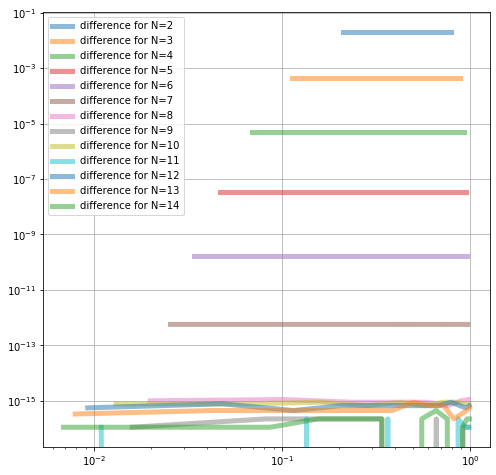

In [16]:
xx = np.linspace(0, 1, 51)
plt.figure(figsize=(8,8)) 



for N in range(2,15):
    x, y = solve_e1(N)
    plt.loglog(x, np.abs(np.sin(np.pi*x) + 2./np.pi-y), '-', lw=5, alpha=0.5, label='difference for N=' + str(N))
    
plt.legend(loc='best')
plt.grid()

We can see that we can begin from N = 8.

### Задание 2.2

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их точное расположение.

1. Для начала, попробуйте интерполировать значения, полученные в предыдущем пункте на равномерной сетке длиной 50. Можете использовать любой метод интерполяции. Сравните интерполяцию с точным значением.

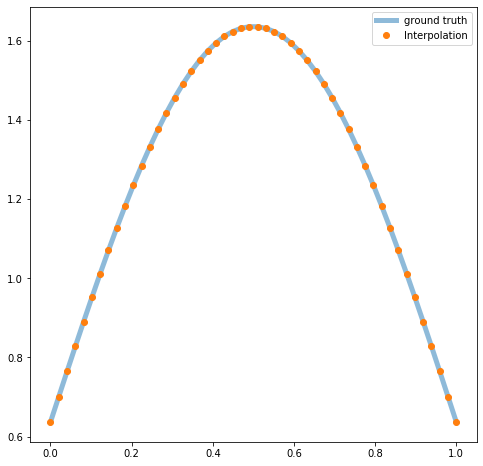

In [43]:
def l_pol(x, x0, y0, m):
    l = np.ones_like(x)
    for j in range(x0.shape[0]):
        if (j != m):
            l *= (x-x0[j])/(x0[m]-x0[j])
    return l
def L_pol(x,x0,y0):
    L=0
    i = 0
    for i in range(x0.shape[0]):
        L += y0[i]*l_pol(x,x0,y0,i)
    return L

x_ = np.linspace(0, 1, 50)
x1, y1 = solve_e1(8)
plt.figure(figsize=(8,8)) 
plt.plot(x_, np.sin(np.pi*x_) + 2./np.pi, '-', lw=5, alpha=0.5,label='ground truth')
plt.plot(x_, L_pol(x_,x1,y1), 'o',label = 'Interpolation')
plt.legend()

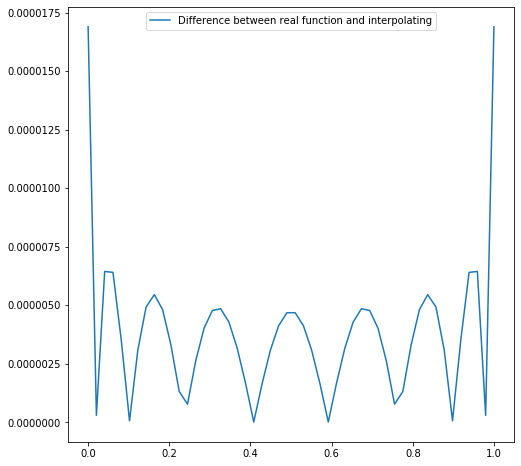

In [37]:
plt.figure(figsize=(8,8)) 
plt.plot(x_, np.abs(np.sin(np.pi*x_) + 2./np.pi-L_pol(x_,x1,y1)), '-', label='Difference between real function and interpolating')
plt.legend()

2. Теперь используйте следующую формулу, чтобы вычислить значение функции на той же равномерной сетке.

$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$

Сравните эту интерполяцию с точным значением, а также с прямым интерполяционным методом.

(20% итогой оценки)

In [80]:
def solut(x,y):
    t, w = roots_sh_legendre(8)
    Wmat = np.zeros((x.shape[0],t.shape[0]))
    for i in range(x.shape[0]):
        for j in range(8):
            Wmat[i,j] = w[j] * K(x[i], t[j])*y[j]
    return g(x) + lmbd*np.sum(Wmat, axis = 1)

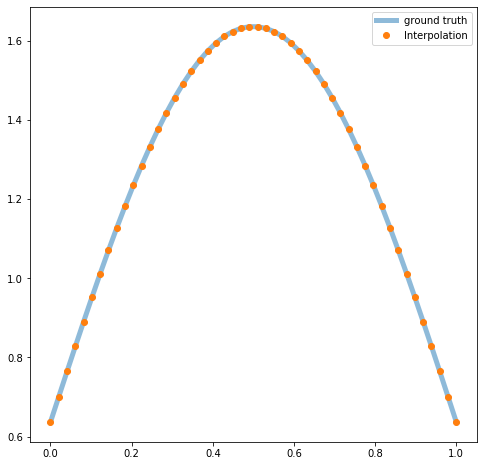

In [81]:
plt.figure(figsize=(8,8)) 
plt.plot(x_, np.sin(np.pi*x_) + 2./np.pi, '-', lw=5, alpha=0.5,label='ground truth')
plt.plot(x_, solut(x_,y1), 'o',label = 'Interpolation')
plt.legend()

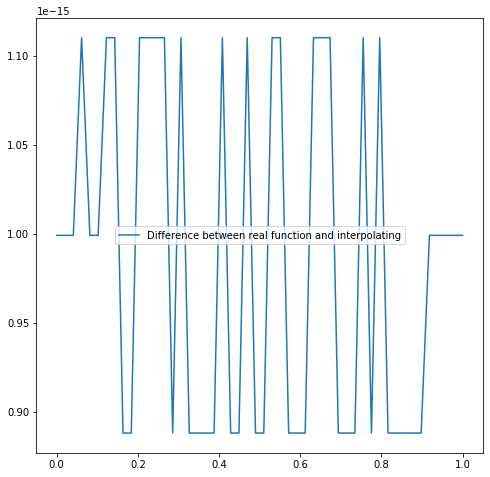

In [84]:
plt.figure(figsize=(8,8)) 
plt.plot(x_, np.abs(np.sin(np.pi*x_) + 2./np.pi-solut(x_,y1)), '-', label='Difference between real function and interpolating')
plt.legend()

We can see that difference in the second case 6 orders less than in the first case.